In [1]:
# import attack_kernelbased
import attack_fgsm_dnn
import attack_df_dnn
# import attack_jsma
import attack_gen_dnn
import dataloader
import spatial

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import numpy as np
import time
import onlinehd
import DNNmodels
import pickle
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tqdm

In [2]:
device = 'cpu'

In [3]:
X_train, X_test, y_train, y_test = dataloader.load(None) # MNIST

classes = y_train.unique().size(0)
features = X_train.size(1)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

/Users/sang-geon/Documents/UCI_BIASLab/kernel_adversarial/venv/lib/python3.8/site-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


(torch.Size([52500, 784]),
 torch.Size([17500, 784]),
 torch.Size([52500]),
 torch.Size([17500]))

In [4]:
X_test = X_test[:1000]
y_test = y_test[:1000]

## CNN

CNN(
  (conv1): Conv2d(1, 16, kernel_size=(4, 4), stride=(1, 1))
  (relu1): ReLU()
  (conv2): Conv2d(16, 8, kernel_size=(2, 2), stride=(1, 1))
  (relu2): ReLU()
  (max_pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1152, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)
Epoch 1
-------------------------------
loss: 2.297185  [    0/52500]
loss: 1.072657  [ 6400/52500]
loss: 0.550835  [12800/52500]
loss: 0.421461  [19200/52500]
loss: 0.233749  [25600/52500]
loss: 0.453348  [32000/52500]
loss: 0.461064  [38400/52500]
loss: 0.454403  [44800/52500]
loss: 0.335714  [51200/52500]
Epoch 2
-------------------------------
loss: 0.247592  [    0/52500]
loss: 0.138405  [ 6400/52500]
loss: 0.375500  [12800/52500]
loss: 0.196346  [19200/52500]
loss: 0.307126  [25600/52500]
loss: 0.206999  [32000/52500]
loss: 0.268244  [38400/52500]
loss: 0.270426  [44800/52500]
loss: 0.370999  [51200/52500]
Epo

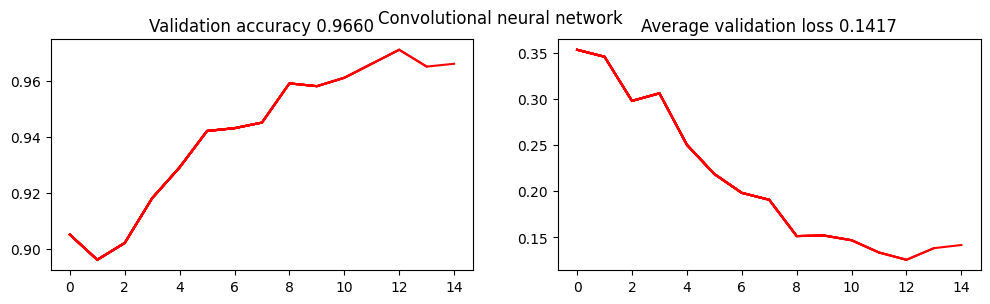

In [13]:
BATCH_SIZE = 64
EPOCHS = 15

training_data = DNNmodels.CustomImageDataset(X_train, y_train, model_type='cnn')
val_data = DNNmodels.CustomImageDataset(X_test, y_test, model_type='cnn')
# create Dataloader for cnn
train_dataloader = DataLoader(training_data, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)

model_cnn = DNNmodels.CNN().to(device)
print(model_cnn)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_cnn.parameters(), lr=0.0005)
early_stop_callback = DNNmodels.EarlyStopping()

fig, axs = plt.subplots(1,2, figsize=(12,3))
plt.suptitle('Convolutional neural network')
result = {'avg_loss':[], 'acc':[], 'epoch':[]}

for t in range(EPOCHS):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model_cnn, loss_fn, optimizer)
    test(val_dataloader, model_cnn, loss_fn, result)
    result['epoch'].append(t)
    early_stop_callback(result['avg_loss'][-1])
    if early_stop_callback.early_stop:
        break
    plot_results(axs, result)

In [17]:
torch.save(model_cnn.state_dict(), './model_cnn.pt')

In [5]:
model_cnn = DNNmodels.CNN()
model_cnn.load_state_dict(torch.load('./model_cnn.pt'))
model_cnn.eval()

CNN(
  (conv1): Conv2d(1, 16, kernel_size=(4, 4), stride=(1, 1))
  (relu1): ReLU()
  (conv2): Conv2d(16, 8, kernel_size=(2, 2), stride=(1, 1))
  (relu2): ReLU()
  (max_pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1152, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [6]:
with open('./onlinehd.pickle', 'br') as f:
    model_onlinehd = pickle.load(f)

### FGSM

100%|██████████| 1000/1000 [00:01<00:00, 674.21it/s]



FGSM Attack with epsilon = 0.01000 | Elapsed time: 1.5694608330000008 seconds.
Accuracy: Before the attack -> 97.20%	|	After the attack -> 95.70%
mean of norm=0.009999999776482582


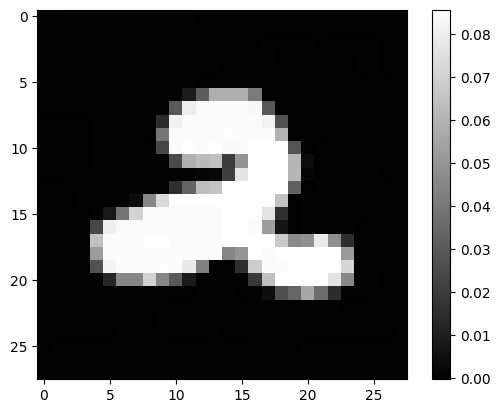

100%|██████████| 1000/1000 [00:01<00:00, 681.06it/s]



FGSM Attack with epsilon = 0.02000 | Elapsed time: 1.4744856249999998 seconds.
Accuracy: Before the attack -> 97.20%	|	After the attack -> 94.50%
mean of norm=0.019999997690320015


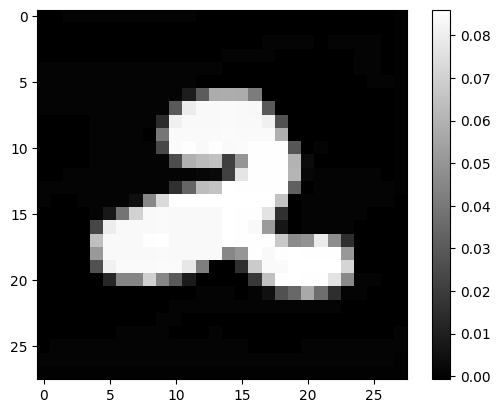

100%|██████████| 1000/1000 [00:01<00:00, 718.50it/s]



FGSM Attack with epsilon = 0.03000 | Elapsed time: 1.3988861250000042 seconds.
Accuracy: Before the attack -> 97.20%	|	After the attack -> 93.20%
mean of norm=0.030000001192092896


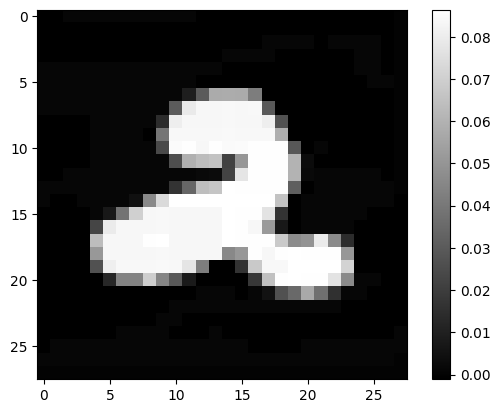

100%|██████████| 1000/1000 [00:01<00:00, 732.46it/s]



FGSM Attack with epsilon = 0.04000 | Elapsed time: 1.3717309170000007 seconds.
Accuracy: Before the attack -> 97.20%	|	After the attack -> 91.30%
mean of norm=0.03999999910593033


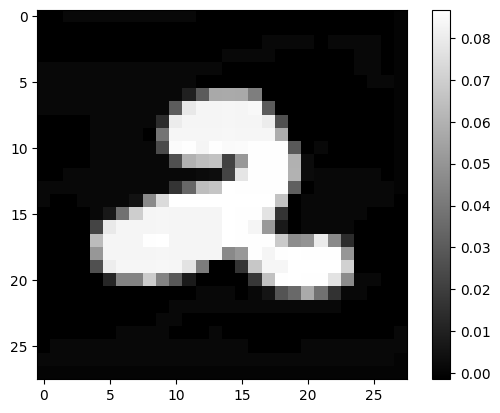

100%|██████████| 1000/1000 [00:01<00:00, 634.41it/s]



FGSM Attack with epsilon = 0.05000 | Elapsed time: 1.583491666999997 seconds.
Accuracy: Before the attack -> 97.20%	|	After the attack -> 88.30%
mean of norm=0.05000000074505806


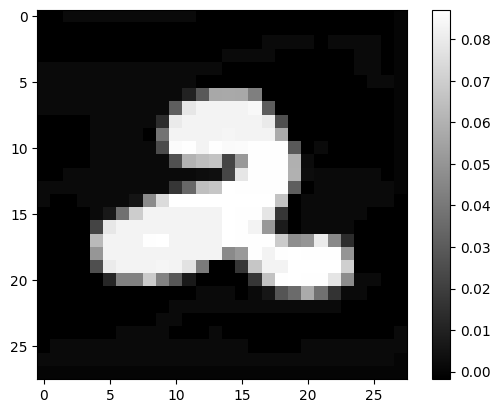

100%|██████████| 1000/1000 [00:01<00:00, 703.86it/s]



FGSM Attack with epsilon = 0.06000 | Elapsed time: 1.4272884590000032 seconds.
Accuracy: Before the attack -> 97.20%	|	After the attack -> 84.90%
mean of norm=0.05999999865889549


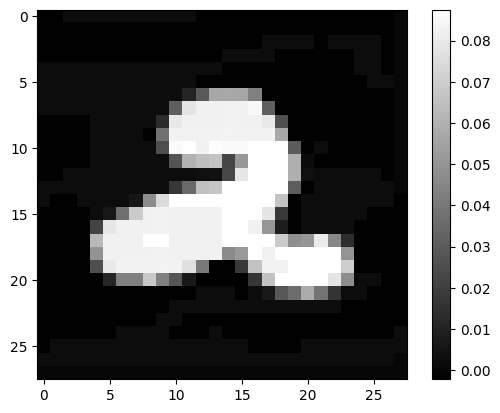

100%|██████████| 1000/1000 [00:01<00:00, 747.24it/s]



FGSM Attack with epsilon = 0.07000 | Elapsed time: 1.3445218330000017 seconds.
Accuracy: Before the attack -> 97.20%	|	After the attack -> 80.80%
mean of norm=0.07000000029802322


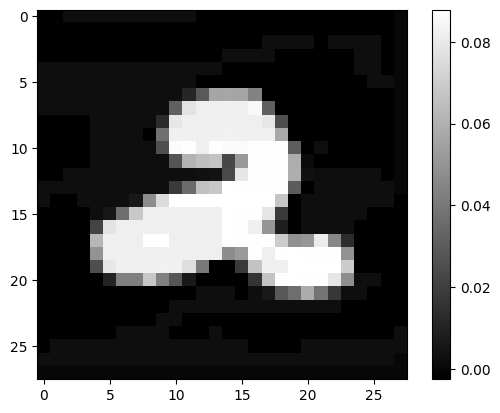

100%|██████████| 1000/1000 [00:01<00:00, 573.98it/s]



FGSM Attack with epsilon = 0.08000 | Elapsed time: 1.749397542000004 seconds.
Accuracy: Before the attack -> 97.20%	|	After the attack -> 74.90%
mean of norm=0.07999999821186066


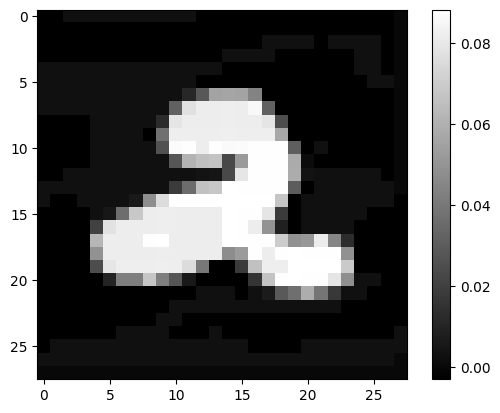

100%|██████████| 1000/1000 [00:01<00:00, 778.45it/s]



FGSM Attack with epsilon = 0.09000 | Elapsed time: 1.2912914579999963 seconds.
Accuracy: Before the attack -> 97.20%	|	After the attack -> 69.00%
mean of norm=0.09000000357627869


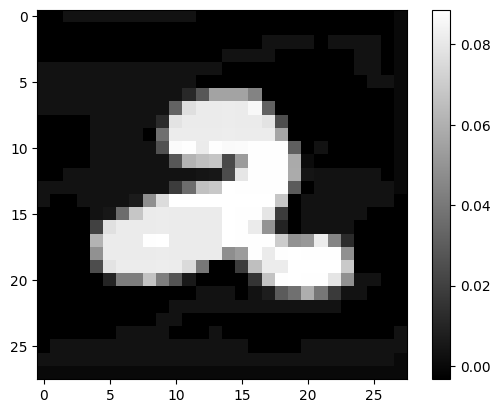

100%|██████████| 1000/1000 [00:01<00:00, 682.95it/s]



FGSM Attack with epsilon = 0.10000 | Elapsed time: 1.4754433749999976 seconds.
Accuracy: Before the attack -> 97.20%	|	After the attack -> 64.00%
mean of norm=0.10000000149011612


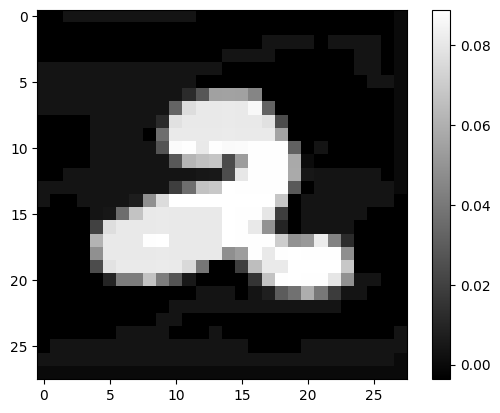

In [7]:
epsilons = np.linspace(0.01, 0.1, 10) # torch.Tensor([0.01, 0.03, 0.07, 0.1])
verbose = False
criterion = nn.CrossEntropyLoss()
#criterion = lambda output, model, label: (spatial.cos_cdist(output, model) - label).mean()
#criterion = lambda output, model, label: output.mean()
N_VAL_SAMPLES = X_test.data.shape[0]

attack_samples, acc_results = attack_fgsm_dnn.attack(
    model_cnn, X_train.reshape(len(X_train), 28, 28), X_test.reshape(len(X_test), 28, 28), y_test, epsilons, classes, criterion, N_VAL_SAMPLES, 'cpu')

In [8]:
for e, X_test_noised in zip(epsilons, attack_samples):
    yhat_test_onlinehd = model_onlinehd(X_test_noised.reshape(-1, 28*28))
    yhat_test_cnn = model_cnn(X_test_noised.reshape(-1, 1, 28, 28)).argmax(1)

    onlinehd_attacked_acc = (y_test == yhat_test_onlinehd).float().mean().item()
    cnn_attacked_acc = (y_test == yhat_test_cnn).float().mean().item()
    distance = (X_test_noised.reshape(-1, 28*28) - X_test).norm(dim=-1).mean().item()

    print(e, distance, onlinehd_attacked_acc, cnn_attacked_acc)

0.01 0.009999999776482582 0.9549999833106995 0.9570000171661377
0.020000000000000004 0.019999997690320015 0.9480000138282776 0.9449999928474426
0.030000000000000006 0.030000001192092896 0.9440000057220459 0.9319999814033508
0.04000000000000001 0.03999999910593033 0.9440000057220459 0.9129999876022339
0.05000000000000001 0.05000000074505806 0.9380000233650208 0.8830000162124634
0.06000000000000001 0.05999999865889549 0.9340000152587891 0.8489999771118164
0.07 0.07000000029802322 0.9259999990463257 0.8080000281333923
0.08 0.07999999821186066 0.9129999876022339 0.7490000128746033
0.09000000000000001 0.09000000357627869 0.9049999713897705 0.6899999976158142
0.1 0.10000000149011612 0.8999999761581421 0.6399999856948853


### Deep Fool

In [10]:
for max_update in np.linspace(0.01, 0.2, 20):
    X_te_cln = X_test.clone().reshape(-1, 1, 28, 28)
    Y_te_cln = y_test.clone()

    x_test_adv = torch.zeros(X_te_cln.shape)
    x_test_pert = torch.zeros(X_te_cln.shape[0], 28, 28)

    st = time.time()
    for i in tqdm.tqdm(range(X_test.shape[0])):
        x_test_adv[i], x_test_pert[i] = attack_df_dnn.deepfool(X_te_cln[i].reshape(1, 28, 28), model_cnn, epsilon=max_update)
    print(time.time() - st)
    
    X_test_noised = x_test_adv.reshape(-1, features)

    yhat_test_onlinehd = model_onlinehd(X_test_noised.reshape(-1, 28*28))
    yhat_test_cnn = model_cnn(X_test_noised.reshape(-1, 1, 28, 28)).argmax(1)

    onlinehd_attacked_acc = (y_test == yhat_test_onlinehd).float().mean().item()
    cnn_attacked_acc = (y_test == yhat_test_cnn).float().mean().item()
    distance = (X_test_noised.reshape(-1, 28*28) - X_test).norm(dim=-1).mean().item()

    print(max_update, distance, onlinehd_attacked_acc, cnn_attacked_acc)

100%|██████████| 1000/1000 [01:40<00:00,  9.98it/s]


100.21458411216736
0.01 0.00792520958930254 0.9539999961853027 0.9549999833106995


100%|██████████| 1000/1000 [01:36<00:00, 10.36it/s]


96.53656911849976
0.02 0.01585041917860508 0.9490000009536743 0.9440000057220459


100%|██████████| 1000/1000 [01:20<00:00, 12.47it/s]


80.16735196113586
0.03 0.023775631561875343 0.9440000057220459 0.9120000004768372


100%|██████████| 1000/1000 [01:13<00:00, 13.65it/s]


73.23939800262451
0.04 0.03170083835721016 0.9409999847412109 0.8640000224113464


100%|██████████| 1000/1000 [01:06<00:00, 14.95it/s]


66.876060962677
0.05 0.03962605446577072 0.9279999732971191 0.8050000071525574


100%|██████████| 1000/1000 [00:58<00:00, 17.23it/s]


58.051953077316284
0.060000000000000005 0.04755126312375069 0.9169999957084656 0.7110000252723694


100%|██████████| 1000/1000 [00:55<00:00, 18.10it/s]


55.2616651058197
0.06999999999999999 0.05547647178173065 0.9089999794960022 0.6399999856948853


100%|██████████| 1000/1000 [00:46<00:00, 21.53it/s]


46.44650387763977
0.08 0.06340167671442032 0.8989999890327454 0.5320000052452087


100%|██████████| 1000/1000 [00:39<00:00, 25.62it/s]


39.02971124649048
0.09 0.07132689654827118 0.8920000195503235 0.4410000145435333


100%|██████████| 1000/1000 [00:34<00:00, 28.60it/s]


34.97123193740845
0.09999999999999999 0.07925210893154144 0.8820000290870667 0.38100001215934753


100%|██████████| 1000/1000 [00:31<00:00, 32.04it/s]


31.20901894569397
0.11 0.08717731386423111 0.8709999918937683 0.33000001311302185


100%|██████████| 1000/1000 [00:28<00:00, 35.11it/s]


28.484506845474243
0.12 0.09510252624750137 0.8629999756813049 0.28700000047683716


100%|██████████| 1000/1000 [00:28<00:00, 35.16it/s]


28.444101095199585
0.13 0.10302773118019104 0.8529999852180481 0.25999999046325684


100%|██████████| 1000/1000 [00:25<00:00, 39.97it/s]


25.01942014694214
0.14 0.1109529435634613 0.8460000157356262 0.23199999332427979


100%|██████████| 1000/1000 [00:24<00:00, 40.19it/s]


24.88016390800476
0.15000000000000002 0.11887814849615097 0.8299999833106995 0.22300000488758087


100%|██████████| 1000/1000 [00:24<00:00, 41.41it/s]


24.148228883743286
0.16 0.12680335342884064 0.8159999847412109 0.21899999678134918


100%|██████████| 1000/1000 [00:24<00:00, 41.30it/s]


24.21412992477417
0.17 0.1347285807132721 0.8090000152587891 0.2150000035762787


100%|██████████| 1000/1000 [00:23<00:00, 41.78it/s]


23.939368963241577
0.18000000000000002 0.14265379309654236 0.7940000295639038 0.2150000035762787


100%|██████████| 1000/1000 [00:23<00:00, 43.19it/s]


23.15256690979004
0.19 0.15057900547981262 0.7799999713897705 0.2150000035762787


100%|██████████| 1000/1000 [00:25<00:00, 38.87it/s]


25.73029589653015
0.2 0.15850421786308289 0.7649999856948853 0.2150000035762787


In [11]:
X_te_cln = X_test.clone().reshape(-1, 1, 28, 28)
Y_te_cln = y_test.clone()

x_test_adv = torch.zeros(X_te_cln.shape)
x_test_pert = torch.zeros(X_te_cln.shape[0], 28, 28)

st = time.time()
for i in tqdm.tqdm(range(X_test.shape[0])):
    x_test_adv[i], x_test_pert[i] = attack_df_dnn.deepfool(X_te_cln[i].reshape(1, 28, 28), model_cnn, epsilon=None)
print(time.time() - st)

X_test_noised = x_test_adv.reshape(-1, features)

yhat_test_onlinehd = model_onlinehd(X_test_noised.reshape(-1, 28*28))
yhat_test_cnn = model_cnn(X_test_noised.reshape(-1, 1, 28, 28)).argmax(1)

onlinehd_attacked_acc = (y_test == yhat_test_onlinehd).float().mean().item()
cnn_attacked_acc = (y_test == yhat_test_cnn).float().mean().item()
distance = (X_test_noised.reshape(-1, 28*28) - X_test).norm(dim=-1).mean().item()

print(None, distance, onlinehd_attacked_acc, cnn_attacked_acc)

100%|██████████| 1000/1000 [00:23<00:00, 43.38it/s]


23.05231285095215
None 0.16146865487098694 0.781000018119812 0.2150000035762787


### Genetic Attack

In [12]:
alpha_lis = np.linspace(0.0001, 0.002, 20) #[0.01, 0.03, 0.07, 0.1]
delta = 0.5
nData = len(alpha_lis)
model_accuracy_GA = np.zeros(nData)

x_test_samp = X_test.cpu()
y_test_samp = y_test.cpu()

for n in range(nData):
    alpha = alpha_lis[n]
    print(f"Alpha : {alpha}")

    st = time.time()
    x_test_GA, _ = attack_gen_dnn.make_GA(model_cnn, delta, alpha, x_test_samp.reshape(-1, 28*28), y_test_samp)
    print(time.time() - st)
    
    X_test_noised = x_test_GA.reshape(-1, features)

    yhat_test = model_onlinehd(X_test_noised.reshape(-1, 28*28))
    yhat_test_cnn = model_cnn(X_test_noised.reshape(-1, 1, 28, 28)).argmax(1)

    onlinehd_attacked_acc = (y_test == yhat_test).float().mean().item()
    cnn_attacked_acc = (y_test == yhat_test_cnn).float().mean().item()
    distance = (X_test_noised.reshape(-1, 28*28) - X_test).norm(dim=-1).mean().item()

    print(alpha, distance, onlinehd_attacked_acc, cnn_attacked_acc)

#model_accuracy_GA

Alpha : 0.0001


100%|██████████| 1000/1000 [33:23<00:00,  2.00s/it]


2003.330106973648
0.0001 0.0029405667446553707 0.9570000171661377 0.9710000157356262
Alpha : 0.0002


100%|██████████| 1000/1000 [34:30<00:00,  2.07s/it]


2070.620232820511
0.0002 0.005878498777747154 0.9570000171661377 0.9710000157356262
Alpha : 0.00030000000000000003


 93%|█████████▎| 928/1000 [32:40<02:36,  2.17s/it]

: 

: 

In [7]:
alpha_lis = np.linspace(0.0001, 0.002, 20) #[0.01, 0.03, 0.07, 0.1]
delta = 0.5
nData = len(alpha_lis)
model_accuracy_GA = np.zeros(nData)

x_test_samp = X_test.cpu()
y_test_samp = y_test.cpu()

for n in range(2, nData):
    alpha = alpha_lis[n]
    print(f"Alpha : {alpha}")

    st = time.time()
    x_test_GA, _ = attack_gen_dnn.make_GA(model_cnn, delta, alpha, x_test_samp.reshape(-1, 28*28), y_test_samp)
    print(time.time() - st)
    
    X_test_noised = x_test_GA.reshape(-1, features)

    yhat_test = model_onlinehd(X_test_noised.reshape(-1, 28*28))
    yhat_test_cnn = model_cnn(X_test_noised.reshape(-1, 1, 28, 28)).argmax(1)

    onlinehd_attacked_acc = (y_test == yhat_test).float().mean().item()
    cnn_attacked_acc = (y_test == yhat_test_cnn).float().mean().item()
    distance = (X_test_noised.reshape(-1, 28*28) - X_test).norm(dim=-1).mean().item()

    print(alpha, distance, onlinehd_attacked_acc, cnn_attacked_acc)

#model_accuracy_GA

Alpha : 0.00030000000000000003


100%|██████████| 1000/1000 [38:07<00:00,  2.29s/it]


2287.2855808734894
0.00030000000000000003 0.008786112070083618 0.9520000219345093 0.9739999771118164
Alpha : 0.0004


100%|██████████| 1000/1000 [38:51<00:00,  2.33s/it]


2331.9237020015717
0.0004 0.01165953278541565 0.953000009059906 0.9710000157356262
Alpha : 0.0005


100%|██████████| 1000/1000 [44:03<00:00,  2.64s/it]


2644.0187859535217
0.0005 0.014438522979617119 0.953000009059906 0.9739999771118164
Alpha : 0.0006000000000000001


100%|██████████| 1000/1000 [49:25<00:00,  2.97s/it]


2965.210088968277
0.0006000000000000001 0.017270248383283615 0.9520000219345093 0.972000002861023
Alpha : 0.0007000000000000001


100%|██████████| 1000/1000 [46:51<00:00,  2.81s/it]


2811.140487909317
0.0007000000000000001 0.0201843474060297 0.9520000219345093 0.9729999899864197
Alpha : 0.0008


100%|██████████| 1000/1000 [45:57<00:00,  2.76s/it]


2757.237431049347
0.0008 0.02296363189816475 0.9520000219345093 0.9739999771118164
Alpha : 0.0009000000000000001


100%|██████████| 1000/1000 [41:10<00:00,  2.47s/it]


2470.456738948822
0.0009000000000000001 0.025799976661801338 0.9509999752044678 0.9729999899864197
Alpha : 0.001


100%|██████████| 1000/1000 [43:36<00:00,  2.62s/it]


2616.37770986557
0.001 0.028515640646219254 0.9509999752044678 0.968999981880188
Alpha : 0.0011


100%|██████████| 1000/1000 [35:41<00:00,  2.14s/it]


2141.600157737732
0.0011 0.03130970522761345 0.9490000009536743 0.9729999899864197
Alpha : 0.0012000000000000001


100%|██████████| 1000/1000 [36:17<00:00,  2.18s/it]


2177.6887788772583
0.0012000000000000001 0.03410769999027252 0.9509999752044678 0.972000002861023
Alpha : 0.0013000000000000002


 22%|██▏       | 220/1000 [08:49<26:11,  2.01s/it]

: 

: 

In [7]:
alpha_lis = np.linspace(0.0001, 0.002, 20) #[0.01, 0.03, 0.07, 0.1]
delta = 0.5
nData = len(alpha_lis)
model_accuracy_GA = np.zeros(nData)

x_test_samp = X_test.cpu()
y_test_samp = y_test.cpu()

for n in range(12, nData):
    alpha = alpha_lis[n]
    print(f"Alpha : {alpha}")

    st = time.time()
    x_test_GA, _ = attack_gen_dnn.make_GA(model_cnn, delta, alpha, x_test_samp.reshape(-1, 28*28), y_test_samp)
    print(time.time() - st)
    
    X_test_noised = x_test_GA.reshape(-1, features)

    yhat_test = model_onlinehd(X_test_noised.reshape(-1, 28*28))
    yhat_test_cnn = model_cnn(X_test_noised.reshape(-1, 1, 28, 28)).argmax(1)

    onlinehd_attacked_acc = (y_test == yhat_test).float().mean().item()
    cnn_attacked_acc = (y_test == yhat_test_cnn).float().mean().item()
    distance = (X_test_noised.reshape(-1, 28*28) - X_test).norm(dim=-1).mean().item()

    print(alpha, distance, onlinehd_attacked_acc, cnn_attacked_acc)

#model_accuracy_GA

Alpha : 0.0013000000000000002


100%|██████████| 1000/1000 [51:09<00:00,  3.07s/it]


3069.2152421474457
0.0013000000000000002 0.03678363561630249 0.9599999785423279 0.9679999947547913
Alpha : 0.0014000000000000002


100%|██████████| 1000/1000 [50:27<00:00,  3.03s/it]


3027.1031098365784
0.0014000000000000002 0.03937864676117897 0.9570000171661377 0.9639999866485596
Alpha : 0.0015


100%|██████████| 1000/1000 [46:24<00:00,  2.78s/it]


2784.8080129623413
0.0015 0.04191560298204422 0.9570000171661377 0.9629999995231628
Alpha : 0.0016


100%|██████████| 1000/1000 [41:52<00:00,  2.51s/it]


2512.244227170944
0.0016 0.04465257376432419 0.9589999914169312 0.9639999866485596
Alpha : 0.0017000000000000001


100%|██████████| 1000/1000 [33:17<00:00,  2.00s/it]


1997.1792631149292
0.0017000000000000001 0.047534577548503876 0.9589999914169312 0.9589999914169312
Alpha : 0.0018000000000000002


 45%|████▌     | 451/1000 [16:27<18:19,  2.00s/it]

: 

: 

In [7]:
alpha_lis = [0.0018, 0.0021, 0.0024, 0.0027, 0.003, 0.0033] #[0.01, 0.03, 0.07, 0.1]
delta = 0.5
nData = len(alpha_lis)
model_accuracy_GA = np.zeros(nData)

x_test_samp = X_test.cpu()
y_test_samp = y_test.cpu()

for n in range(nData):
    alpha = alpha_lis[n]
    print(f"Alpha : {alpha}")

    st = time.time()
    x_test_GA, _ = attack_gen_dnn.make_GA(model_cnn, delta, alpha, x_test_samp.reshape(-1, 28*28), y_test_samp)
    print(time.time() - st)
    
    X_test_noised = x_test_GA.reshape(-1, features)

    yhat_test = model_onlinehd(X_test_noised.reshape(-1, 28*28))
    yhat_test_cnn = model_cnn(X_test_noised.reshape(-1, 1, 28, 28)).argmax(1)

    onlinehd_attacked_acc = (y_test == yhat_test).float().mean().item()
    cnn_attacked_acc = (y_test == yhat_test_cnn).float().mean().item()
    distance = (X_test_noised.reshape(-1, 28*28) - X_test).norm(dim=-1).mean().item()

    print(alpha, distance, onlinehd_attacked_acc, cnn_attacked_acc)

#model_accuracy_GA

Alpha : 0.0018


100%|██████████| 1000/1000 [41:32<00:00,  2.49s/it]


2492.0887439250946
0.0018 0.05007711052894592 0.9620000123977661 0.9660000205039978
Alpha : 0.0021


100%|██████████| 1000/1000 [43:11<00:00,  2.59s/it]


2591.484085083008
0.0021 0.05754612386226654 0.9589999914169312 0.9639999866485596
Alpha : 0.0024


100%|██████████| 1000/1000 [40:20<00:00,  2.42s/it]


2420.032078027725
0.0024 0.064783476293087 0.9549999833106995 0.9679999947547913
Alpha : 0.0027


100%|██████████| 1000/1000 [32:11<00:00,  1.93s/it]


1931.324951171875
0.0027 0.07135935872793198 0.9559999704360962 0.9649999737739563
Alpha : 0.003


 88%|████████▊ | 878/1000 [27:59<03:46,  1.86s/it]

: 

: 

In [7]:
alpha_lis = [0.003, 0.0033] #[0.01, 0.03, 0.07, 0.1]
delta = 0.5
nData = len(alpha_lis)
model_accuracy_GA = np.zeros(nData)

x_test_samp = X_test.cpu()
y_test_samp = y_test.cpu()

for n in range(nData):
    alpha = alpha_lis[n]
    print(f"Alpha : {alpha}")

    st = time.time()
    x_test_GA, _ = attack_gen_dnn.make_GA(model_cnn, delta, alpha, x_test_samp.reshape(-1, 28*28), y_test_samp)
    print(time.time() - st)
    
    X_test_noised = x_test_GA.reshape(-1, features)

    yhat_test = model_onlinehd(X_test_noised.reshape(-1, 28*28))
    yhat_test_cnn = model_cnn(X_test_noised.reshape(-1, 1, 28, 28)).argmax(1)

    onlinehd_attacked_acc = (y_test == yhat_test).float().mean().item()
    cnn_attacked_acc = (y_test == yhat_test_cnn).float().mean().item()
    distance = (X_test_noised.reshape(-1, 28*28) - X_test).norm(dim=-1).mean().item()

    print(alpha, distance, onlinehd_attacked_acc, cnn_attacked_acc)

#model_accuracy_GA

Alpha : 0.003


100%|██████████| 1000/1000 [31:21<00:00,  1.88s/it]


1881.5780861377716
0.003 0.07712962478399277 0.9380000233650208 0.9449999928474426
Alpha : 0.0033


100%|██████████| 1000/1000 [32:39<00:00,  1.96s/it]


1959.79341506958
0.0033 0.08267205208539963 0.9399999976158142 0.9580000042915344


In [8]:
alpha_lis = [0.0035, 0.0037] #[0.01, 0.03, 0.07, 0.1]
delta = 0.5
nData = len(alpha_lis)
model_accuracy_GA = np.zeros(nData)

x_test_samp = X_test.cpu()
y_test_samp = y_test.cpu()

for n in range(nData):
    alpha = alpha_lis[n]
    print(f"Alpha : {alpha}")

    st = time.time()
    x_test_GA, _ = attack_gen_dnn.make_GA(model_cnn, delta, alpha, x_test_samp.reshape(-1, 28*28), y_test_samp)
    print(time.time() - st)
    
    X_test_noised = x_test_GA.reshape(-1, features)

    yhat_test = model_onlinehd(X_test_noised.reshape(-1, 28*28))
    yhat_test_cnn = model_cnn(X_test_noised.reshape(-1, 1, 28, 28)).argmax(1)

    onlinehd_attacked_acc = (y_test == yhat_test).float().mean().item()
    cnn_attacked_acc = (y_test == yhat_test_cnn).float().mean().item()
    distance = (X_test_noised.reshape(-1, 28*28) - X_test).norm(dim=-1).mean().item()

    print(alpha, distance, onlinehd_attacked_acc, cnn_attacked_acc)

#model_accuracy_GA

Alpha : 0.0035


100%|██████████| 1000/1000 [38:12<00:00,  2.29s/it]


2292.496792793274
0.0035 0.08569066226482391 0.9409999847412109 0.9419999718666077
Alpha : 0.0037


100%|██████████| 1000/1000 [34:53<00:00,  2.09s/it]


2093.656594991684
0.0037 0.08819904923439026 0.9399999976158142 0.9490000009536743


In [9]:
alpha_lis = [0.004, 0.0043] #[0.01, 0.03, 0.07, 0.1]
delta = 0.5
nData = len(alpha_lis)
model_accuracy_GA = np.zeros(nData)

x_test_samp = X_test.cpu()
y_test_samp = y_test.cpu()

for n in range(nData):
    alpha = alpha_lis[n]
    print(f"Alpha : {alpha}")

    st = time.time()
    x_test_GA, _ = attack_gen_dnn.make_GA(model_cnn, delta, alpha, x_test_samp.reshape(-1, 28*28), y_test_samp)
    print(time.time() - st)
    
    X_test_noised = x_test_GA.reshape(-1, features)

    yhat_test = model_onlinehd(X_test_noised.reshape(-1, 28*28))
    yhat_test_cnn = model_cnn(X_test_noised.reshape(-1, 1, 28, 28)).argmax(1)

    onlinehd_attacked_acc = (y_test == yhat_test).float().mean().item()
    cnn_attacked_acc = (y_test == yhat_test_cnn).float().mean().item()
    distance = (X_test_noised.reshape(-1, 28*28) - X_test).norm(dim=-1).mean().item()

    print(alpha, distance, onlinehd_attacked_acc, cnn_attacked_acc)

#model_accuracy_GA

Alpha : 0.004


100%|██████████| 1000/1000 [39:12<00:00,  2.35s/it]


2352.298187017441
0.004 0.09091316163539886 0.9399999976158142 0.9449999928474426
Alpha : 0.0043


100%|██████████| 1000/1000 [38:28<00:00,  2.31s/it]


2308.893455028534
0.0043 0.09434465318918228 0.9430000185966492 0.9440000057220459
